<a href="https://colab.research.google.com/github/BrotherKim/Colab/blob/main/SEP592/BK_resnet50_BRCA_classification_32_100_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Dataset 형태
datasets<br>
    &emsp;&emsp;└── test_set<br>
    &emsp;&emsp;│   &emsp;&emsp;├── class1<br>
    &emsp;&emsp;│   &emsp;&emsp;│   &emsp;&emsp;└── datas...<br>
    &emsp;&emsp;│   &emsp;&emsp;└── class2<br>
    &emsp;&emsp;│       &emsp;&emsp;&emsp;&emsp;&emsp;└── datas...<br>
    &emsp;&emsp;└── training_set<br>
        &emsp;&emsp;&emsp;&emsp;├── class1<br>
        &emsp;&emsp;&emsp;&emsp;│   &emsp;&emsp;└── datas...<br>
        &emsp;&emsp;&emsp;&emsp;└── class2<br>
            &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;└── datas...<br>


# Parameter 및 Basemodel 설정

In [2]:
IMAGE_SIZE = 224
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
NUM_CLASSES = 2
WEIGHT_DIR_PATH = '/content/gdrive/MyDrive/KAIST/SEP592/checkpoints'
WEIGHT_FILE_PATH = 'resnet50_brca_32_100_10.h5'

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

baseModel = ResNet50(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE, classes=NUM_CLASSES)
#baseMode =ResNet50(include_top=True, weights=None, input_shape=INPUT_SHAPE, classes=NUM_CLASSES)

baseModel.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [4]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 위노그라드 알고리즘 설정
os.environ['TF_ENABLE_WINOGRAD_NONFUSED'] = '1'

#rootPath = '/content/datasets'
rootPath = '/content/gdrive/MyDrive/KAIST/dataset'

imageGenerator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[.2, .2],
    horizontal_flip=True,
    validation_split=.1
)

# Data Load

In [5]:
!ls -l /content/gdrive/MyDrive/KAIST/dataset/test_set

total 8
drwx------ 2 root root 4096 May 30 05:32 lym
drwx------ 2 root root 4096 May 30 05:32 normal


In [6]:
trainGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train_set'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    subset='training'
)

validationGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'train_set'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    subset='validation'
)

Found 21181 images belonging to 2 classes.
Found 2352 images belonging to 2 classes.


# Model setting

In [7]:
for i, l in enumerate(baseModel.layers):
  print(i, l.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [8]:
from keras.models import Model
from tensorflow.keras.layers import Flatten, Dropout, Conv2D, MaxPooling2D, Dense, BatchNormalization

x = baseModel.output
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', input_dim=INPUT_SHAPE)(x)
x = BatchNormalization()(x)
x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(
    inputs=baseModel.input
    , outputs=x
    )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 33,160,322
Trainable params: 33,105,666
Non-trainable params: 54,656
__________________________________________________________________________________________________


# Finetuning

In [9]:
NUM_FREEZE = 100

for l in baseModel.layers:
  l.trainable = False

for l in baseModel.layers[NUM_FREEZE:]:
  l.trainable = True


In [10]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

In [11]:
#epochs = 32
#history = model.fit_generator(
#    trainGen, 
#    epochs=epochs,
#    steps_per_epoch=trainGen.samples / epochs, 
#    validation_data=validationGen,
#    validation_steps=trainGen.samples / epochs,
#)
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

model_ckpt = ModelCheckpoint('%s/%s' % (WEIGHT_DIR_PATH, WEIGHT_FILE_PATH),save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=1)
early_stop = EarlyStopping(patience=10,verbose=2,monitor='loss')

epochs = 32
history = model.fit_generator(
    trainGen, 
    epochs=epochs,
    steps_per_epoch=100, 
    validation_data=validationGen,
    validation_steps=100,
    callbacks=[reduce_lr,early_stop],
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/32
100/100 [==============================] - 1026s 10s/step - loss: 1.3330 - acc: 0.7718 - val_loss: 0.5264 - val_acc: 0.7889
Epoch 2/32
100/100 [==============================] - 604s 6s/step - loss: 0.5409 - acc: 0.7793 - val_loss: 0.5483 - val_acc: 0.7849
Epoch 3/32
100/100 [==============================] - 604s 6s/step - loss: 0.5502 - acc: 0.7816 - val_loss: 0.5196 - val_acc: 0.7879
Epoch 4/32
100/100 [==============================] - 608s 6s/step - loss: 0.5211 - acc: 0.7875 - val_loss: 0.5204 - val_acc: 0.7886
Epoch 5/32
100/100 [==============================] - 612s 6s/step - loss: 0.5218 - acc: 0.7871 - val_loss: 0.5160 - val_acc: 0.7905
Epoch 6/32
100/100 [==============================] - 602s 6s/step - loss: 0.5350 - acc: 0.7729 - val_loss: 0.5238 - val_acc: 0.7825
Epoch 7/32
100/100 [==============================] - 407s 4s/step - loss: 0.5050 - acc: 0.7979 - val_loss: 0.5098 - val_acc: 0.7937
Epoch 8/32
100/100 [==============================] - 88s 891ms/ste

In [12]:
#model.save_weights("/content/gdrive/MyDrive/KAIST/SEP592/checkpoints/resnet50_brca_ckpt")
!mkdir -p WEIGHT_DIR_PATH
model.save_weights('%s/%s' % (WEIGHT_DIR_PATH, WEIGHT_FILE_PATH))

# `assert_consumed` can be used as validation that all variable values have been
# restored from the checkpoint. See `tf.train.Checkpoint.restore` for other
# methods in the Status object.
#load_status.assert_consumed()

#학습 결과 시각화

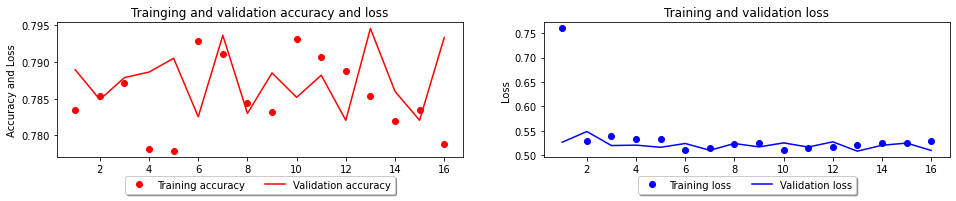

In [13]:
import matplotlib.pyplot as plt

def show_graph(history_dict):
    accuracy = history_dict['acc']
    val_accuracy = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(16, 1))
    
    plt.subplot(121)
    plt.subplots_adjust(top=2)
    plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Trainging and validation accuracy and loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy and Loss')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, -0.1))

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend(bbox_to_anchor=(1, 0))

    plt.show()
show_graph(history.history)


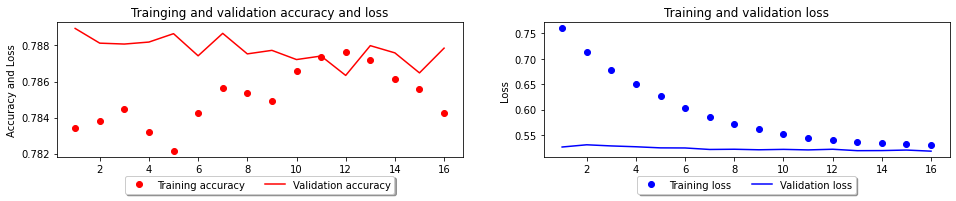

In [14]:
def smooth_curve(points, factor=.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_data = {}
for key, val in history.history.items():
    smooth_data[key] = smooth_curve(val)
show_graph(smooth_data)


#모델 평가

In [ ]:
load_status = model.load_weights('%s/%s' % (WEIGHT_DIR_PATH, WEIGHT_FILE_PATH))

In [15]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy', 
    metrics=['acc'],
)

In [16]:
testGenerator = ImageDataGenerator(
    rescale=1./255
)

testGen = imageGenerator.flow_from_directory(
    os.path.join(rootPath, 'test_set'),
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
)

Found 9816 images belonging to 2 classes.


In [63]:
#model.evaluate_generator(testGen)
evaluation = model.evaluate_generator(testGen, verbose=1, steps=308)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


300/300 [==============================] - 132s 443ms/step - loss: 0.4762 - acc: 0.8179


In [64]:
evaluation

[0.47622835636138916, 0.8178690671920776]

In [61]:
#Predicting the classes of images
prediction = model.predict_generator(testGen, verbose=1, steps=308)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


300/300 [==============================] - 131s 440ms/step


In [62]:
import numpy as np

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(testGen.class_indices)
print(prediction)

{'lym': 0, 'normal': 1}
[[0.062 0.938]
 [0.062 0.938]
 [0.062 0.938]
 ...
 [0.062 0.938]
 [0.062 0.938]
 [0.062 0.938]]


In [79]:
len(testGen.labels)
#for i in range(100):

# answer가 0인데 predict가 1이면 failCntArr[0]++
failCntArr = [0, 0]
allCntArr = [0, 0]
for i in range(len(prediction)):
  prdIdx = 1 if prediction[i][0] < prediction[i][1] else 0
  ansIdx = testGen.labels[i]
  allCntArr[ansIdx] += 1

  if prdIdx == ansIdx : continue
  print('[FAIL] predict[%d], answer[%d]' % (prdIdx, ansIdx))
  failCntArr[ansIdx] += 1

print('Pass cnt : lym[%d/%d], normal[%d/%d]' % (failCntArr[0], allCntArr[0], failCntArr[1], allCntArr[1]))

[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict[1], answer[0]
[FAIL] predict